<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
# PATH_TO_DATA = '/tmp/working/machinleaning/ml/6/ident/data/capstone_user'
PATH_TO_DATA = '/tmp/working/machinlearning/6/ident/data/capstone_user/'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
!pwd

/tmp/working/machinlearning/6/ident/week_4


In [4]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [5]:
X_sparse_10users.shape

(14061, 4913)

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [2]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(n_neighbors=100,n_jobs=-1)

In [13]:
scoring = cross_val_score(knn, X_train, y_train, scoring = 'accuracy', cv = skf)

In [14]:
ans_1=np.mean(scoring)

In [15]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [16]:
ans_2=knn.score(X_valid,y_valid)

**Запишите в файл *answer4_1.txt* доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [17]:
print((ans_1,ans_2))

(0.56471888700633621, 0.58402465039108797)


In [18]:
write_answer_to_file('0.565 0.584',
                     'answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
forest = RandomForestClassifier(random_state=17,n_jobs=-1,n_estimators=100,oob_score=True)

In [21]:
%%time
forest.fit(X_train,y_train)

CPU times: user 24.4 s, sys: 40 ms, total: 24.4 s
Wall time: 6.66 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=17, verbose=0, warm_start=False)

In [22]:
ans_1=forest.oob_score_

In [23]:
ans_2=forest.score(X_valid,y_valid)

In [24]:
write_answer_to_file('0.725 0.734',
                     'answer4_2.txt')

In [25]:
ans_2=forest.score(X_valid,y_valid)

In [26]:
print(ans_1,ans_2)

0.719264377159 0.734297226831


**Запишите в файл *answer4_2.txt* доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке на и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [27]:
write_answer_to_file('0.725 0.734',
                     'answer4_2.txt')

In [28]:
!cat answer4_2.txt

0.725 0.734

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [29]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [30]:
logit = LogisticRegression(random_state=17,n_jobs=-1,multi_class='ovr')

In [31]:
cross_val_score(logit,X_train,y_train,cv=skf,n_jobs=-1)

array([ 0.75616438,  0.76974687,  0.75716901])

In [32]:
logit.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
logit.score(X_valid,y_valid)

0.78170182507703245

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [34]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1,cv=skf,\
                                            multi_class='multinomial',random_state=17,n_jobs=-1,scoring='accuracy') 
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.75 s, sys: 92 ms, total: 3.84 s
Wall time: 26 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [35]:
logit_grid_searcher1

LogisticRegressionCV(Cs=array([  1.00000e-04,   4.64159e-04,   2.15443e-03,   1.00000e-02,
         4.64159e-02,   2.15443e-01,   1.00000e+00,   4.64159e+00,
         2.15443e+01,   1.00000e+02]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring='accuracy',
           solver='lbfgs', tol=0.0001, verbose=0)

In [36]:
score_array1 = np.array(list(logit_grid_searcher1.scores_.values()))

In [37]:
logit_mean_cv_scores1 = np.apply_over_axes(np.mean,score_array1,[0,1]).\
reshape(-1)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [38]:
logit_mean_cv_scores1.reshape(-1)

array([ 0.31822225,  0.47337913,  0.55273512,  0.65119285,  0.71297117,
        0.75137565,  0.75889418,  0.75747451,  0.75026107,  0.73938838])

In [39]:
np.where(logit_c_values1==1)

(array([6]),)

In [40]:
logit_mean_cv_scores1[6]

0.75889418487465476

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

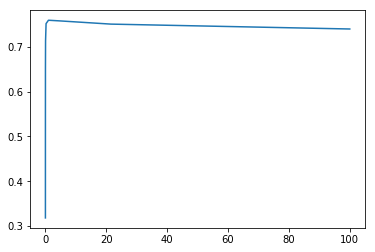

In [86]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);
plt.savefig("LogisticRegressionCV.svg")

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(3, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [49]:
%%time
logit_c_values2 = np.linspace(3, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2,cv=skf,\
                                            multi_class='multinomial',random_state=17,n_jobs=-1,scoring='accuracy')
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 3.64 s, sys: 144 ms, total: 3.78 s
Wall time: 59.2 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [50]:
score_array2 = np.array(list(logit_grid_searcher2.scores_.values()))

In [51]:
''' ВАШ КОД ЗДЕСЬ '''
logit_mean_cv_scores2 = np.apply_over_axes(np.mean,score_array2,[0,1]).\
reshape(-1)

In [52]:
logit_mean_cv_scores2

array([ 0.75960708,  0.75696595,  0.75706826,  0.75727111,  0.75656   ,
        0.7565601 ,  0.75615369,  0.75584905,  0.75564627,  0.75584943,
        0.75554545,  0.75503781,  0.75473337,  0.75463211,  0.75463236,
        0.75463254,  0.75453067,  0.7545307 ,  0.75392125,  0.75392104])

In [53]:
logit_grid_searcher2.score(X_valid,y_valid)

0.77885754918227068

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [54]:
''' ВАШ КОД ЗДЕСЬ '''
logit_grid_searcher2.C_

array([ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

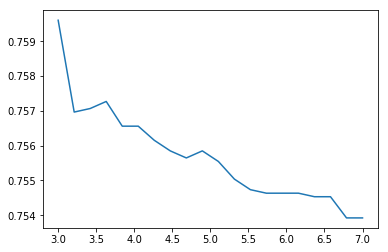

In [87]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);
plt.savefig("LogisticRegressionCV2.svg")

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [56]:
logit_cv_acc =  ''' ВАШ КОД ЗДЕСЬ '''

**Запишите в файл *answer4_3.txt* доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [57]:
write_answer_to_file('0.760 0.780',
                     'answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [58]:
from sklearn.svm import LinearSVC

In [59]:
svm = LinearSVC(C=1,random_state=17)

In [60]:
scoring = cross_val_score(svm, X_train, y_train, scoring = 'accuracy', cv = skf, n_jobs=-1)

In [61]:
scoring

array([ 0.74672755,  0.76029277,  0.75106772])

In [62]:
svm.fit(X_train,y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0)

In [63]:
svm.score(X_valid,y_valid)

0.77696136525242954

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm,svm_params1,n_jobs=-1,verbose=True,cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   34.5s finished


CPU times: user 3.46 s, sys: 48 ms, total: 3.51 s
Wall time: 37.9 s


In [68]:
results_svm_params_1=svm_grid_searcher1.cv_results_

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [69]:
''' ВАШ КОД ЗДЕСЬ '''
max(results_svm_params_1['mean_test_score'])

0.68421052631578949

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

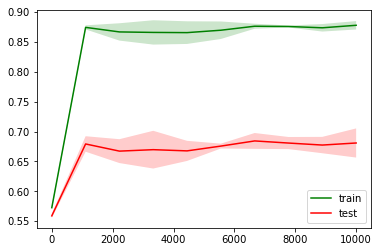

In [88]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)
plt.savefig("validation_curves1.svg")

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [71]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 =  GridSearchCV(svm,svm_params2,n_jobs=-1,cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 948 ms, sys: 196 ms, total: 1.14 s
Wall time: 1min 3s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [72]:
results_svm_params_2=svm_grid_searcher2.cv_results_

In [73]:
max(results_svm_params_2['mean_test_score'])

0.76468197520829095

In [74]:
np.argmax(results_svm_params_2['mean_test_score'])

3

In [75]:
svm_params2['C'][3]

0.10434482758620689

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

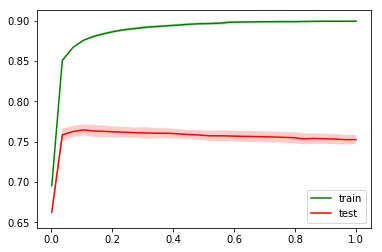

In [89]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)
plt.savefig("validation_curves2.svg")

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [77]:
svm_grid_searcher2.score(X_valid,y_valid)

0.78075373311211183

**Запишите в файл *answer4_4.txt* доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [3]:
write_answer_to_file('''0.765 0.781 ''',
                     'answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [79]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    ''' ВАШ КОД ЗДЕСЬ '''
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
#     from IPython.core.debugger import Tracer; Tracer()()
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    
    scoring1 = cross_val_score(estimator, X_train, y_train, scoring = 'accuracy', cv = cv, n_jobs=-1)
    
    estimator.fit(X_train,y_train)
    scoring2 = estimator.score(X_valid,y_valid)
    return scoring1.mean(),scoring2
    

**Убедитесь, что функция работает.**

In [80]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.76468532445509807, 0.78075373311211183)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [81]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [ ]:
# X_sparse_10users_s10_w5.pkl
# y_10users_s5_w5.pkl

In [82]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA,\
                                     'X_sparse_10users_s{0}_w{1}.pkl'.\
                                     format(session_length,window_size))

        path_to_y_pkl = os.path.join(PATH_TO_DATA,\
                                     'y_10users_s{0}_w{1}.pkl'.\
                                    format(session_length,window_size))
        print(window_size,session_length)
        print(model_assessment(svm_grid_searcher2.best_estimator_, 
                 path_to_X_pkl,
        path_to_y_pkl, skf, random_state=17, test_size=0.3))

10 15
(0.82382149552781048, 0.84048352690210948)
10 10
(0.76468532445509807, 0.78075373311211183)
7 15
(0.84794037698440983, 0.85432221669155473)
7 10
(0.79708721957886686, 0.80736684917869583)
7 7
(0.75298911148303416, 0.76173884187821472)
5 15
(0.86800137255434695, 0.87529634898055952)
5 10
(0.81592472053180387, 0.82456140350877194)
5 7
(0.77405867456322597, 0.78532479848269321)
5 5
(0.72528306503988282, 0.73624940730203892)
CPU times: user 14.7 s, sys: 372 ms, total: 15.1 s
Wall time: 33.9 s


**Запишите в файл *answer4_5.txt* доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [4]:
write_answer_to_file('''0.872 0.877''', 
                     'answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA,\
                                     'X_sparse_150users_s{0}_w{1}.pkl'.\
                                     format(session_length,window_size))

    path_to_y_pkl = os.path.join(PATH_TO_DATA,\
                                 'y_150users_s{0}_w{1}.pkl'.\
                                format(session_length,window_size))
    print(window_size,session_length)
    print(model_assessment(svm_grid_searcher2.best_estimator_, 
             path_to_X_pkl,
    path_to_y_pkl, skf, random_state=17, test_size=0.3))

**Запишите в файл *answer4_6.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_150users*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [6]:
write_answer_to_file('''0.461 0.484''', 
                     'answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [42]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [43]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [44]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=3,cv=skf,\
                                            multi_class='ovr',random_state=17,n_jobs=-1,scoring='accuracy')
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 7min 13s, sys: 6.13 s, total: 7min 19s
Wall time: 18min 39s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [55]:
logit_cv_150users.scores_

{1: array([[ 0.98441794,  0.996003  ,  0.99622158],
        [ 0.98438966,  0.99630858,  0.99599575],
        [ 0.98439996,  0.99552047,  0.9954265 ]]),
 2: array([[ 0.99569073,  0.99634649,  0.99665876],
        [ 0.9957142 ,  0.99640243,  0.99612088],
        [ 0.99570842,  0.99642891,  0.99646023]]),
 3: array([[ 0.99441044,  0.99525356,  0.99484761],
        [ 0.9944003 ,  0.9951511 ,  0.99480698],
        [ 0.99439276,  0.99526987,  0.99486264]]),
 4: array([[ 0.9847302 ,  0.99203722,  0.99172496],
        [ 0.9847025 ,  0.99221047,  0.99158481],
        [ 0.98471322,  0.99157347,  0.99091564]]),
 5: array([[ 0.98794654,  0.99016363,  0.99000749],
        [ 0.98795595,  0.99014578,  0.9899268 ],
        [ 0.98793973,  0.99032046,  0.98994455]]),
 6: array([[ 0.99444167,  0.99453535,  0.99331751],
        [ 0.99446287,  0.99468185,  0.99305512],
        [ 0.99445541,  0.99445541,  0.9935783 ]]),
 7: array([[ 0.99253685,  0.99375468,  0.9930677 ],
        [ 0.99255459,  0.9938372 ,  

In [60]:
cv_scores_by_user = []
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user.append(logit_cv_150users.scores_[user_id])
    print('User {}, CV score: {}'.\
          format(user_id,logit_cv_150users.scores_[user_id]))


User 1, CV score: [[ 0.98441794  0.996003    0.99622158]
 [ 0.98438966  0.99630858  0.99599575]
 [ 0.98439996  0.99552047  0.9954265 ]]
User 2, CV score: [[ 0.99569073  0.99634649  0.99665876]
 [ 0.9957142   0.99640243  0.99612088]
 [ 0.99570842  0.99642891  0.99646023]]
User 3, CV score: [[ 0.99441044  0.99525356  0.99484761]
 [ 0.9944003   0.9951511   0.99480698]
 [ 0.99439276  0.99526987  0.99486264]]
User 4, CV score: [[ 0.9847302   0.99203722  0.99172496]
 [ 0.9847025   0.99221047  0.99158481]
 [ 0.98471322  0.99157347  0.99091564]]
User 5, CV score: [[ 0.98794654  0.99016363  0.99000749]
 [ 0.98795595  0.99014578  0.9899268 ]
 [ 0.98793973  0.99032046  0.98994455]]
User 6, CV score: [[ 0.99444167  0.99453535  0.99331751]
 [ 0.99446287  0.99468185  0.99305512]
 [ 0.99445541  0.99445541  0.9935783 ]]
User 7, CV score: [[ 0.99253685  0.99375468  0.9930677 ]
 [ 0.99255459  0.9938372   0.99349309]
 [ 0.99254456  0.9935783   0.99313974]]
User 8, CV score: [[ 0.98391831  0.98607295  0.9

In [62]:
from itertools import chain

In [93]:
[*chain(*cv_scores_by_user)][0:100]

[array([ 0.98441794,  0.996003  ,  0.99622158]),
 array([ 0.98438966,  0.99630858,  0.99599575]),
 array([ 0.98439996,  0.99552047,  0.9954265 ]),
 array([ 0.99569073,  0.99634649,  0.99665876]),
 array([ 0.9957142 ,  0.99640243,  0.99612088]),
 array([ 0.99570842,  0.99642891,  0.99646023]),
 array([ 0.99441044,  0.99525356,  0.99484761]),
 array([ 0.9944003 ,  0.9951511 ,  0.99480698]),
 array([ 0.99439276,  0.99526987,  0.99486264]),
 array([ 0.9847302 ,  0.99203722,  0.99172496]),
 array([ 0.9847025 ,  0.99221047,  0.99158481]),
 array([ 0.98471322,  0.99157347,  0.99091564]),
 array([ 0.98794654,  0.99016363,  0.99000749]),
 array([ 0.98795595,  0.99014578,  0.9899268 ]),
 array([ 0.98793973,  0.99032046,  0.98994455]),
 array([ 0.99444167,  0.99453535,  0.99331751]),
 array([ 0.99446287,  0.99468185,  0.99305512]),
 array([ 0.99445541,  0.99445541,  0.9935783 ]),
 array([ 0.99253685,  0.99375468,  0.9930677 ]),
 array([ 0.99255459,  0.9938372 ,  0.99349309]),
 array([ 0.99254456,

In [97]:
np.mean(sum([*chain(*cv_scores_by_user)][0:150])/150)

0.9936183118271491

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [ ]:
class_distr = np.bincount(y_train_150.astype('int'))

for user_id in np.unique(y_train_150):
    ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**Запишите в файл *answer4_7.txt* долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой. **

In [ ]:
write_answer_to_file(''' ВАШ КОД ЗДЕСЬ ''', 
                     'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
В этом проекте свобода творчества на каждом шаге, а 7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взимному оцениванию. Что еще можно добавить по 4 части проекта:
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can4) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/identify-me-if-you-can4) Kaggle Inclass.